In [2]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt

import hugs
from hugs.database.tables import Source, Synth
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord

In [18]:
from hugs.log import logger

In [12]:
def match_synths(hugs_cat, synth_cat, min_sep=1.0*u.arcsec):

    if type(hugs_cat) != Table:
        hugs_cat = Table.from_pandas(hugs_cat)
    if type(synth_cat) != Table:
        synth_cat = Table.from_pandas(synth_cat)

    hugs_coord = SkyCoord(hugs_cat['ra'], hugs_cat['dec'], unit='deg')
    synth_coord = SkyCoord(synth_cat['ra'], synth_cat['dec'], unit='deg')

    logger.info('finding nearest neighbor within {:.1f}'.\
                format(min_sep))
    hugs_idx_1, sep_1, _ = synth_coord.match_to_catalog_sky(hugs_coord, 1)
    synth_mask_1 = sep_1 < min_sep
    synth_match = synth_cat[synth_mask_1]

    logger.info('finding second nearest neighbor within {:.1f}'.\
                format(min_sep))
    hugs_idx_2, sep_2, _ = synth_coord.match_to_catalog_sky(hugs_coord, 2)
    synth_mask_2 = sep_2 < min_sep

    synth_mask_12 = synth_mask_1 & synth_mask_2
    synth_match_12 = synth_cat[synth_mask_12]

    hugs_match_1 = hugs_cat[hugs_idx_1][synth_mask_12]
    hugs_match_2 = hugs_cat[hugs_idx_2][synth_mask_12]

    logger.info('keeping match with better radius measurement')
    diff_1 = np.abs(synth_match_12['r_e'] - hugs_match_1['flux_radius_50_i'])
    diff_2 = np.abs(synth_match_12['r_e'] - hugs_match_2['flux_radius_50_i'])
    switch_match = diff_1 > diff_2

    logger.warn('switching {} matches'.format(switch_match.sum()))
    mask_idx = np.argwhere(synth_mask_12)[~switch_match]
    synth_mask_12[mask_idx] = False

    hugs_idx_1[synth_mask_12] = hugs_idx_2[synth_mask_12]
    hugs_match = hugs_cat[hugs_idx_1[synth_mask_1]]

    return hugs_match, synth_match

In [5]:
db_fn = '/tigress/jgreco/hsc-s18a/synths/global/'\
        'synths-detect-g-mask-i-high15/synths-detect-g-high15.db'
engine = hugs.database.connect(db_fn)
session = hugs.database.Session()

In [6]:
size_cut_low = 2.5
size_cut_high = 100.0
m, b = 0.7, 0.4

color_line_lo =  lambda _x: m*_x - b
color_line_hi =  lambda _x: m*_x + b
gi = Source.mag_ap9_g - Source.mag_ap9_i
gr = Source.mag_ap9_g - Source.mag_ap9_r

query = session.query(Source)\
    .filter(Source.flux_radius_65_g > size_cut_low)\
    .filter(Source.flux_radius_65_g < size_cut_high)\
    .filter(gi > -0.1)\
    .filter(gi < 1.4)\
    .filter(color_line_lo(gi) < gr)\ 
    .filter(color_line_hi(gi) > gr)

cat = pd.read_sql(query.statement, engine)

hugs_r_e = cat['flux_radius_60_g'] + cat['flux_radius_65_g']
hugs_r_e *= 0.5
cat['flux_radius_ave_g'] = hugs_r_e

hugs_mu_ave = cat['mag_auto_g'].copy()
hugs_mu_ave += 2.5 * np.log10(2*np.pi*cat['flux_radius_50_g']**2)
cat['mu_ave_g'] = hugs_mu_ave

mu_cut = (cat['mu_ave_g'] > 22.5) & (cat['mu_ave_g'] < 29.0)
cat = cat[mu_cut]

In [285]:
mu_cut = (cat['mu_ave_g'] > 22.5) & (cat['mu_ave_g'] < 29.0)



In [284]:
len(mu_cut) - mu_cut.sum()

86337

In [286]:
len(mu_cut) - mu_cut.sum()

0

In [8]:
synth_query = session.query(Synth)
synth_ids = pd.read_sql(synth_query.statement, engine)


In [9]:
synth_id_unique, synth_id_idx = np.unique(synth_ids['synth_id'].values,
                                          return_index=True)
injected_synth = synth_ids.iloc[synth_id_idx]

In [13]:
from astropy.table import Table

In [15]:
synth_cat = Table.read('/tigress/jgreco/hsc-s18a/synths/global/global-synth-cat.fits')

In [19]:
hugs_match, synth_match = match_synths(
    cat, synth_cat, min_sep=1.0*u.arcsec)

INFO: finding nearest neighbor within 1.0 arcsec
INFO: finding second nearest neighbor within 1.0 arcsec
INFO: keeping match with better radius measurement


/tigress/HSC/LSST/stack_tiger2-sumire.princeton.edu_20181028/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead


In [54]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from hugs.utils import ra_dec_to_xyz, angular_dist_to_euclidean_dist
from hugs.utils import euclidean_dist_to_angular_dist
from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree

In [268]:
xyz = np.array(ra_dec_to_xyz(cat['ra'], cat['dec'])).T

In [269]:
kdt = cKDTree(xyz)

In [281]:
r = 0.2 

In [280]:
r.to('deg').value

5.555555555555556e-05

In [271]:
ind = kdt.query_pairs(angular_dist_to_euclidean_dist(r / 3600.0), output_type='ndarray')

In [272]:
np.unique(ind[:, 1]).size - len(ind)

-60105

In [273]:
len(cat) - len(ind)

881444

In [274]:
ind[:, 1]

array([311774, 311600, 311839, ..., 617452, 617469, 617281])

In [264]:
cat_drop = cat.drop(cat.index[ind[:, 1]])

In [265]:
len(cat_drop)

941549

In [267]:
xyz = np.array(ra_dec_to_xyz(cat_drop['ra'], cat_drop['dec'])).T
kdt = cKDTree(xyz)
ind = kdt.query_pairs(angular_dist_to_euclidean_dist(r / 3600.0), output_type='ndarray')

len(ind)

0

In [210]:
mu_diffs = cat.iloc[ind[:, 0]]['mu_ave_g'].values -\
           cat.iloc[ind[:, 1]]['mu_ave_g'].values
err_diffs = cat.iloc[ind[:, 0]]['magerr_auto_g'].values -\
            cat.iloc[ind[:, 1]]['magerr_auto_g'].values
re_diffs = cat.iloc[ind[:, 0]]['flux_radius_ave_g'].values -\
           cat.iloc[ind[:, 1]]['flux_radius_ave_g'].values

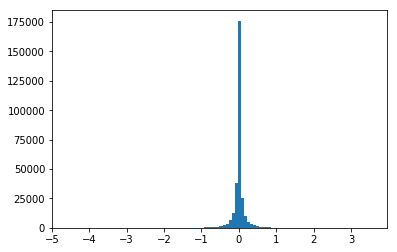

In [212]:
plt.hist(mu_diffs, bins=100);

In [249]:
cut = np.abs(mu_diffs) < 0.0001
cut.sum() / len(cut), cut.sum(), len(cut) - cut.sum()

(0.1629657559606912, 47975, 246412)

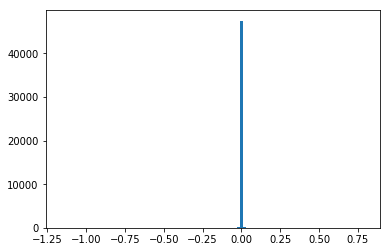

In [250]:
re_diffs = cat.iloc[ind[cut][:, 0]]['flux_radius_ave_g'].values -\
           cat.iloc[ind[cut][:, 1]]['flux_radius_ave_g'].values

plt.hist(re_diffs, bins=100);

In [226]:
ind_re_diff_large = ind[cut][np.abs(re_diffs) > 5]

In [236]:
np.minimum(cat.iloc[ind_re_diff_large[:, 0]]['flux_radius_ave_g'].values, 
           cat.iloc[ind_re_diff_large[:, 1]]['flux_radius_ave_g'].values).max()



19.430208

In [240]:
np.abs(re_diffs).argmax()

45311

In [241]:
cat.iloc[ind[cut][45311, 0]]['flux_radius_ave_g']

17.214624

In [242]:
cat.iloc[ind[cut][45311, 1]]['flux_radius_ave_g']

7.309344

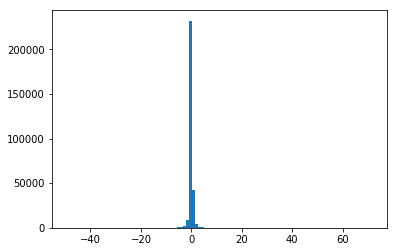

In [179]:
plt.hist(re_diffs, bins=100);

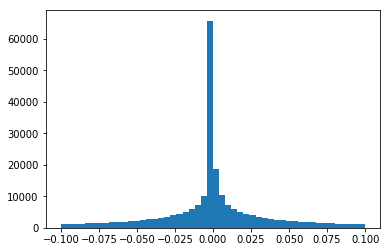

In [188]:
cut = np.abs(diffs) < 0.1
plt.hist(diffs[cut], bins=50);

In [190]:
ind_mu_close = ind[cut]

In [193]:
diffs_mu_close = cat.iloc[ind_mu_close[:, 0]]['flux_radius_ave_g'].values -\
                 cat.iloc[ind_mu_close[:, 1]]['flux_radius_ave_g'].values



In [195]:
diffs_mu_close.min()

-35.265384

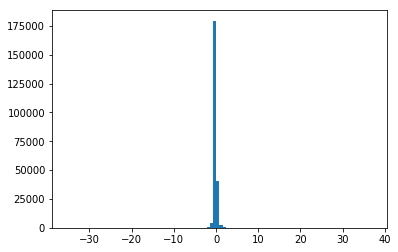

In [194]:
plt.hist(diffs_mu_close, bins=100);

In [157]:
diffs.max()

3.5532887376882094

In [120]:
len(ind) - np.unique(ind[:, 0]).size

71316

In [121]:
cat_coord = SkyCoord(cat['ra'], cat['dec'], unit='deg')

In [122]:
len(cat_coord)

1200080

In [64]:
seps = cat_coord.separation(cat_coord)

In [66]:
idx = []


for current_idx, coord in enumerate(cat_coord[:5]):
    seps = coord.separation(cat_coord)
    seps.arcsec < 0.2

In [ ]:
np.random.choice()

In [ ]:
cat.drop()

In [287]:
cat_drop

,id,x_image,y_image,x_hsc,y_hsc,ra,dec,a_image,b_image,theta_image,...,flux_radius_70_i,flux_radius_80_i,flux_radius_90_i,ebv,A_g,A_r,A_i,patch_id,flux_radius_ave_g,mu_ave_g
0,1,3199.0901,334.8130,35099.0901,12234.8130,216.979709,-1.012697,25.658,8.949,-22.32,...,6.600048,8.047872,8.492736,0.035861,0.115938,0.082157,0.058632,15,5.936028,26.792886
1,2,1926.7645,307.5956,33826.7645,12207.5956,217.039082,-1.013981,25.780,16.008,41.60,...,7.526736,9.126432,10.503360,0.036615,0.118377,0.083886,0.059866,15,6.088404,25.593216
2,3,2983.0515,49.0607,34883.0515,11949.0607,216.989788,-1.026033,4.250,2.950,42.73,...,3.022152,3.194184,3.397800,0.035878,0.115993,0.082196,0.058660,15,2.880696,27.537522
3,8,2467.5564,19.1681,34367.5564,11919.1681,217.013844,-1.027434,3.430,2.173,82.72,...,2.482032,2.665152,2.907576,0.036194,0.117017,0.082921,0.059178,15,2.570904,27.833400
4,12,3029.4189,110.8220,34929.4189,12010.8220,216.987625,-1.023151,4.082,3.451,-62.23,...,3.223752,3.474912,4.114152,0.035875,0.115984,0.082189,0.058656,15,3.399732,27.759571
5,13,3601.7561,230.5243,35501.7561,12130.5243,216.960918,-1.017558,19.009,9.978,61.28,...,7.763112,8.926848,10.854312,0.035735,0.115531,0.081869,0.058427,15,6.142836,26.956966
6,14,2441.1755,122.2299,34341.1755,12022.2299,217.015075,-1.022625,5.743,3.363,-77.87,...,4.119024,4.684344,5.288640,0.036198,0.117029,0.082930,0.059184,15,4.694340,27.887191
7,15,2463.2124,112.0154,34363.2124,12012.0154,217.014047,-1.023101,6.210,2.246,-37.85,...,3.446352,3.731280,3.901968,0.036179,0.116967,0.082886,0.059153,15,2.721852,27.848685
8,16,3113.4792,383.9294,35013.4792,12283.9294,216.983705,-1.010406,38.318,21.530,-46.11,...,16.919448,23.041704,24.311952,0.035894,0.116047,0.082234,0.058687,15,10.562496,26.656480
9,20,3169.9219,303.1509,35069.9219,12203.1509,216.981070,-1.014175,25.048,10.358,-10.25,...,7.791840,8.107512,9.843792,0.035865,0.115950,0.082166,0.058639,15,5.803392,26.645805
